In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from scipy import stats
from scipy.stats import uniform, randint

# Feature Engineering & Selection
from boruta import BorutaPy
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV, f_classif, chi2

# Model Selection & Metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, log_loss

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Configuration
warnings.filterwarnings('ignore')

In [30]:
df_data_raw = pd.read_csv('data.csv')
df_data_raw.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [28]:
df_data_raw.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

* Só temos valores faltantes para o Income.

In [31]:
df_filtered = df_data_raw[df_data_raw['Income'].isnull()]
df_filtered.head(24)
missing_income_idx = df_data_raw[df_data_raw['Income'].isnull()].index

* Parece que os valores faltandes de Income referem-se a pessoas mais velhas.

In [7]:
# Número de linhas duplicadas
df_data_raw.duplicated().sum()

0

In [8]:
# Número de colunas duplicadas
df_data_raw.T.duplicated().sum()

0

In [236]:
df_data_raw.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

* Todos os tipos de variável parecem condizentes com a descrição, porém esperaria que o montante gasto nos diferentes produtos fosse float (como o income) ao invés de int.

In [13]:
df_data_raw.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


* No geral os valores parecem estar dentro do esperado. É digno de nota que um cliente nasceu em 1893. 

## EDA

In [14]:
df_data_raw.value_counts('Response', normalize = True) # 15% dos clientes aderiram a pesquisa

Response
0    0.850893
1    0.149107
Name: proportion, dtype: float64

In [32]:
df_train, df_test = train_test_split(df_data_raw, train_size = 0.8, stratify = df_data_raw['Response'])

### Classe Social/ Renda

  * A primeira questão que temos que resolver é como tratar os valores faltantes de 'Income'. Como uma primeira análise, iremos avaliar como o 'Income' varia de acordo com a idade ('Age'), o nível de educação ('Education') e o estado civil ('Marital_Status').

<Axes: xlabel='Age', ylabel='Income'>

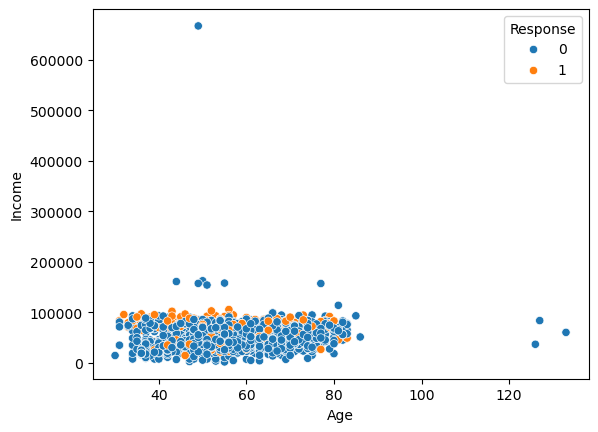

In [16]:
df_train['Age'] = 2026 - df_train['Year_Birth']
sns.scatterplot(data = df_train, x = 'Age', y = 'Income', hue = 'Response')

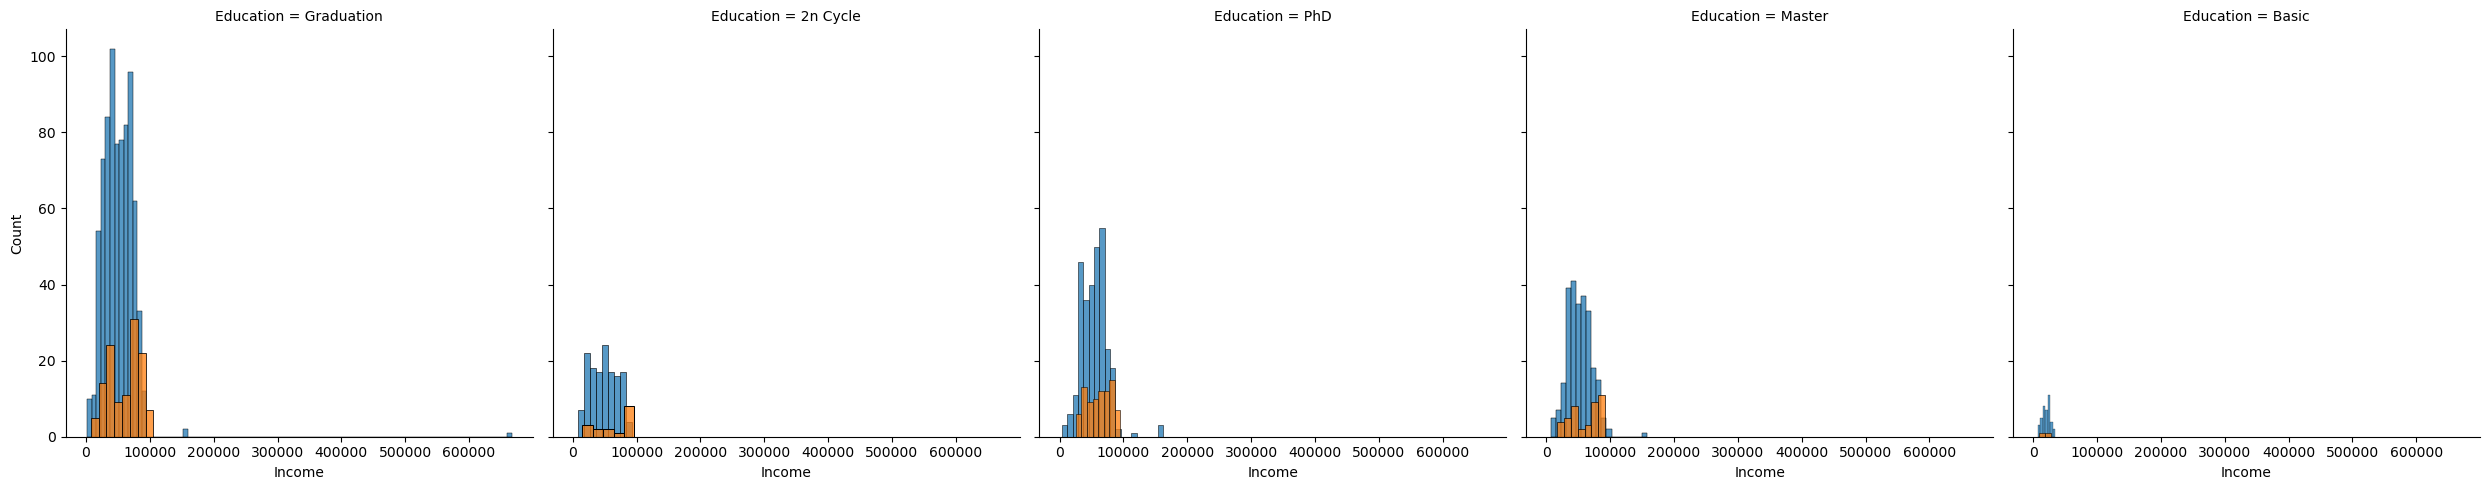

In [17]:
g = sns.FacetGrid(df_train, hue = 'Response', col = 'Education' , height = 5, aspect = 1)
g.tight_layout()
g.map(sns.histplot, 'Income')

In [18]:
df_train.groupby('Education').describe()['Income']

,count,mean,std,min,25%,50%,75%,max
Education,,,,,,,,
2n Cycle,158.0,49554.607595,22157.160250,7500.0,31163.00,47822.0,67456.75,96547.0
Basic,42.0,20656.238095,6257.102874,7500.0,15897.75,22256.5,24882.00,34445.0
Graduation,900.0,52376.544444,29680.799034,1730.0,34802.50,50755.0,69158.75,666666.0
Master,294.0,53130.156463,20368.204587,6560.0,38260.00,50954.0,66835.00,157733.0
PhD,378.0,55953.994709,20586.913625,4023.0,39492.50,55472.5,69078.75,162397.0


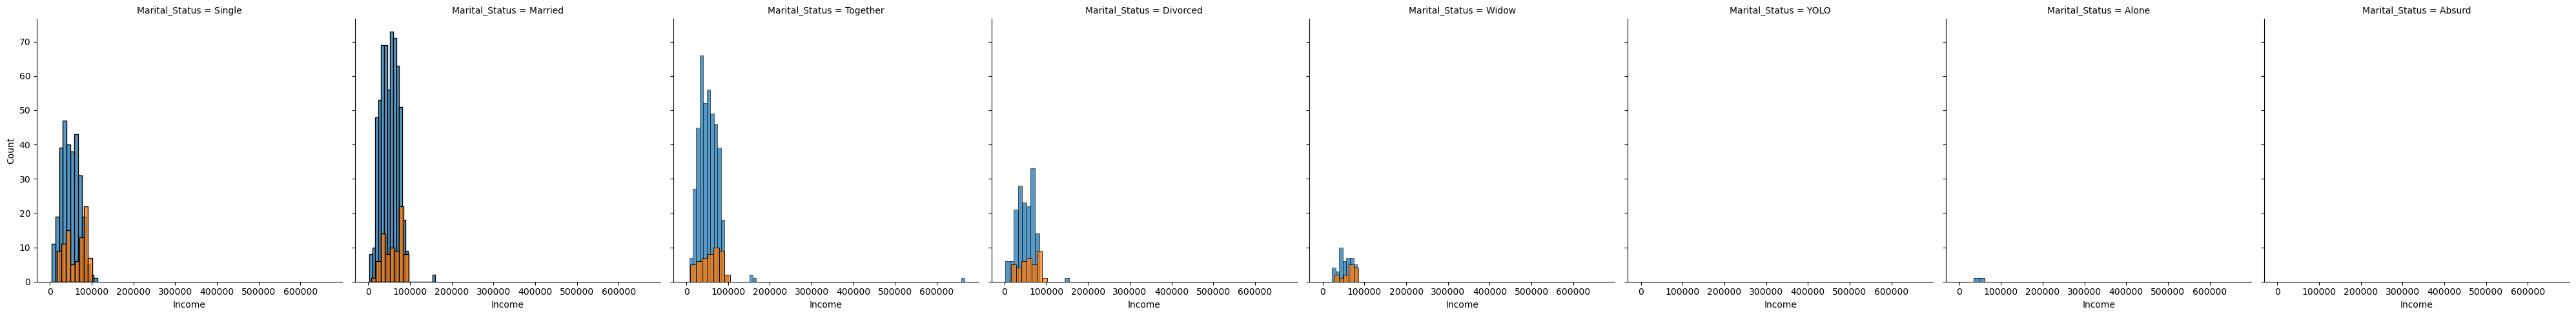

In [19]:
g = sns.FacetGrid(df_train, hue = 'Response', col = 'Marital_Status', height = 5, aspect = 1)
g.tight_layout()
g.map(sns.histplot, 'Income')

In [20]:
df_train.groupby('Marital_Status').describe()['Income']

,count,mean,std,min,25%,50%,75%,max
Marital_Status,,,,,,,,
Absurd,1.0,79244.000000,NaN,79244.0,79244.00,79244.0,79244.00,79244.0
Alone,3.0,43789.000000,15215.133486,34176.0,35018.00,35860.0,48595.50,61331.0
Divorced,191.0,51571.418848,21541.848861,1730.0,36243.50,51813.0,67582.50,153924.0
Married,678.0,51856.589971,21363.217877,2447.0,35816.75,51650.5,68480.75,160803.0
Single,383.0,51292.801567,22551.519220,3502.0,33558.00,49494.0,69445.00,113734.0
Together,458.0,53495.436681,35935.198527,6835.0,35227.50,51342.0,67561.25,666666.0
Widow,56.0,56152.125000,16727.311990,22123.0,44322.75,57032.0,67868.75,85620.0
YOLO,2.0,48432.000000,0.000000,48432.0,48432.00,48432.0,48432.00,48432.0


In [245]:
df_train.groupby('Marital_Status').describe()['Income']

,count,mean,std,min,25%,50%,75%,max
Marital_Status,,,,,,,,
Absurd,1.0,79244.000000,NaN,79244.0,79244.00,79244.0,79244.00,79244.0
Alone,2.0,47753.500000,19201.484643,34176.0,40964.75,47753.5,54542.25,61331.0
Divorced,183.0,52939.939891,22056.834325,1730.0,36633.50,53034.0,69408.00,153924.0
Married,689.0,51768.402032,20765.697455,2447.0,35765.00,52531.0,67445.00,160803.0
Single,370.0,51068.897297,22740.417382,3502.0,33265.75,48646.5,70219.50,113734.0
Together,465.0,52861.154839,35994.390094,5648.0,34320.00,50334.0,67419.00,666666.0
Widow,60.0,56621.866667,16688.193540,25358.0,44664.00,55453.5,68629.00,85620.0
YOLO,2.0,48432.000000,0.000000,48432.0,48432.00,48432.0,48432.00,48432.0


* No gráfico 1 vemos que não há uma forte relação entre a idade do comprador e a sua renda. Em relação ao nível de educação, vemos que há uma clara diferença entre o nível básico e os demais. No entanto, todos os níveis restantes estão bem próximos entre si (2n Cycle, Graduation, Master, PhD).

* Em suma, à excessão dos níveis mais baixos, não existe uma forte relação entre renda e os parâmetros análisados. Podemos no entanto, aprofundar nossa investigação usando os dados referentes aos gastos de cada cliente no aplicativo. O argumento aqui é extremamente intuitivo, clientes que gastam mais, por óbvio, devem ganhar mais. Para isso iremos criar uma feature de gastos totais e dividi-la em faixas (usando os quartis).

In [33]:
spent_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_train['Total_spent'] = df_train[spent_cols].sum(axis=1)

## Dividindo os valores gastos em quartis 1 = primeiro quartil, 2 = segundo quartil..
df_train['Spending_Class'] = pd.qcut(df_train['Total_spent'], q=[0, 0.25, 0.5, 0.75, 1], labels=[1, 2, 3, 4])

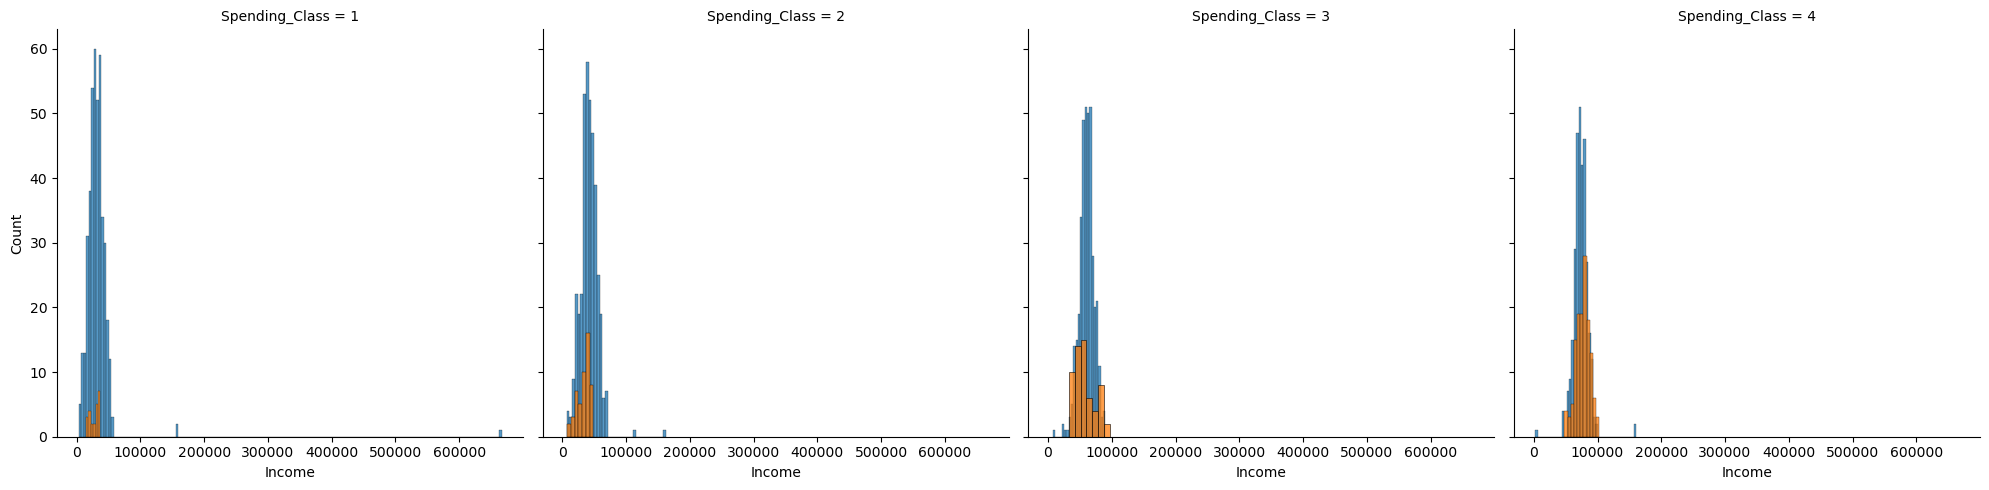

In [34]:
g = sns.FacetGrid(df_train, hue = 'Response', col = 'Spending_Class', height = 5, aspect = 1)
g.tight_layout()
g.map(sns.histplot, 'Income')

In [35]:
df_train.groupby('Spending_Class').describe()['Income']

,count,mean,std,min,25%,50%,75%,max
Spending_Class,,,,,,,,
1,448.0,32653.051339,32954.470216,3502.0,23261.00,30617.5,37758.50,666666.0
2,438.0,40833.289954,13978.503694,6560.0,33384.00,40569.0,48787.25,162397.0
3,442.0,60071.334842,12223.599058,7144.0,52867.50,60009.0,67332.75,96547.0
4,446.0,74935.562780,12196.882489,2447.0,68468.25,75006.0,81831.00,160803.0


* Vemos uma clara distinção entre a renda dos diferentes níveis, por isso iremos usar essa informação para completar os dados faltantes de income.

In [36]:
# 1. Calculando as medianas
medians = df_train.groupby('Spending_Class')['Income'].median()
dict_class = medians.to_dict()

# 2. Preenchendo valores faltantes
df_train['Income'] = df_train['Income'].fillna(
    df_train.groupby('Spending_Class')['Income'].transform('median')
)

In [26]:
df_train.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
Age                    0
Total_spent            0
Spending_Class         0
dtype: int64

In [43]:
### Dividindo o Income de acordo com os quartis.
df_train['Income_Class'] = pd.qcut(df_train['Income'],q=[0, 0.25, 0.5, 0.75, 1], labels = [1,2,3,4])





### Income

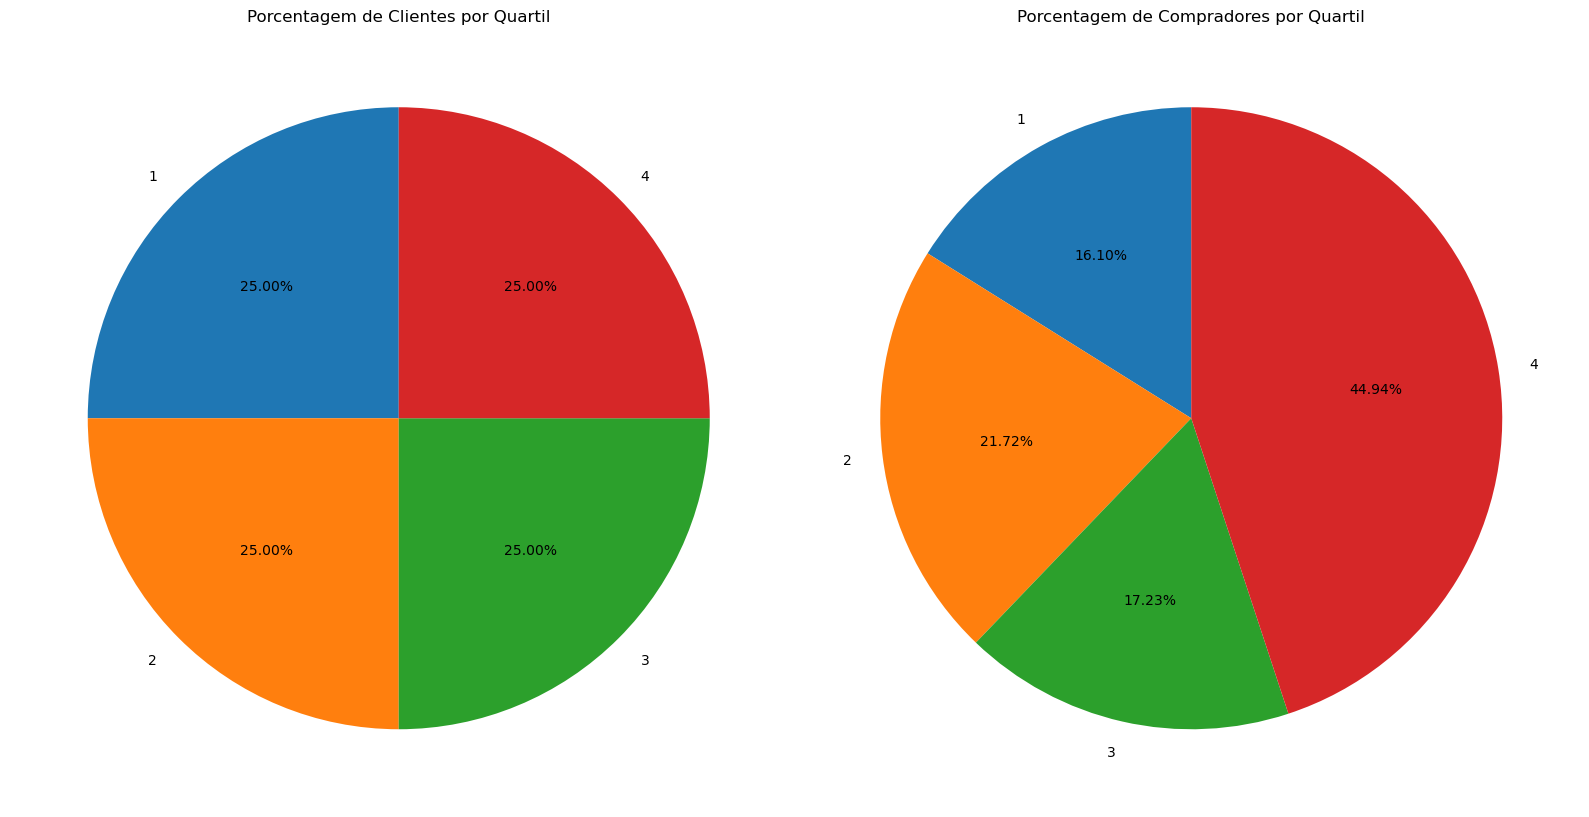

In [44]:
# Tabela de Frequencia (index = Income_Class, columns = Response)
ct = pd.crosstab(df_train['Income_Class'], df_train['Response'])

fig, ax = plt.subplots(1, 2, figsize=(16, 9))

# Plot 1: Total Distribution (Sum of columns 0 and 1)
ax[0].pie(ct.sum(axis=1), labels=ct.index, autopct='%1.2f%%', startangle=90)
ax[0].set_title('Porcentagem de Clientes por Quartil')

# Plot 2: Just the Buyers (Column 1)
ax[1].pie(ct[1], labels=ct.index, autopct='%1.2f%%', startangle=90)
ax[1].set_title('Porcentagem de Compradores por Quartil')

plt.tight_layout()
plt.show()

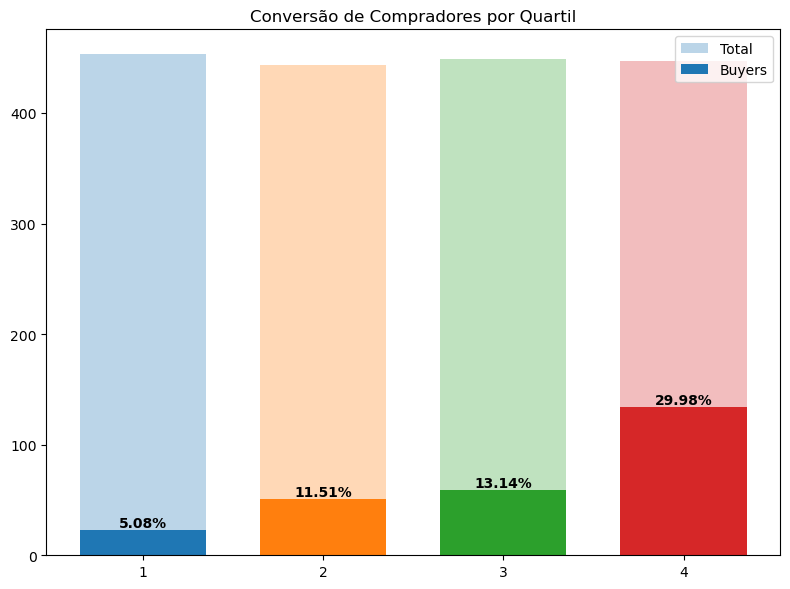

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

# Settings
ind = np.arange(len(ct))  
width = 0.7              
colors = ['C0', 'C1', 'C2', 'C3']

# Plotting - Using the crosstab (ct) data directly
# ct.sum(axis=1)  Total, ct[1] Compradores
bar1 = ax.bar(ind, ct.sum(axis=1), width=width, color=colors, alpha=0.3, label='Total')
bar2 = ax.bar(ind, ct[1], width=width, color=colors, label='Buyers')

# Adding labels
for i, rect in enumerate(bar2):
    total = ct.sum(axis=1).iloc[i]
    buyers = ct[1].iloc[i]
    
    # Calculate percentage safely
    percentage = (buyers / total) * 100
    
    ax.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), 
            f'{percentage:.2f}%', ha='center', va='bottom', fontweight='bold')

# Formatting
ax.set_xticks(ind)
ax.set_xticklabels(ct.index) # Uses the actual class names from the data
ax.set_title('Conversão de Compradores por Quartil')
ax.legend()

plt.tight_layout()
plt.show()

### Amount Spent

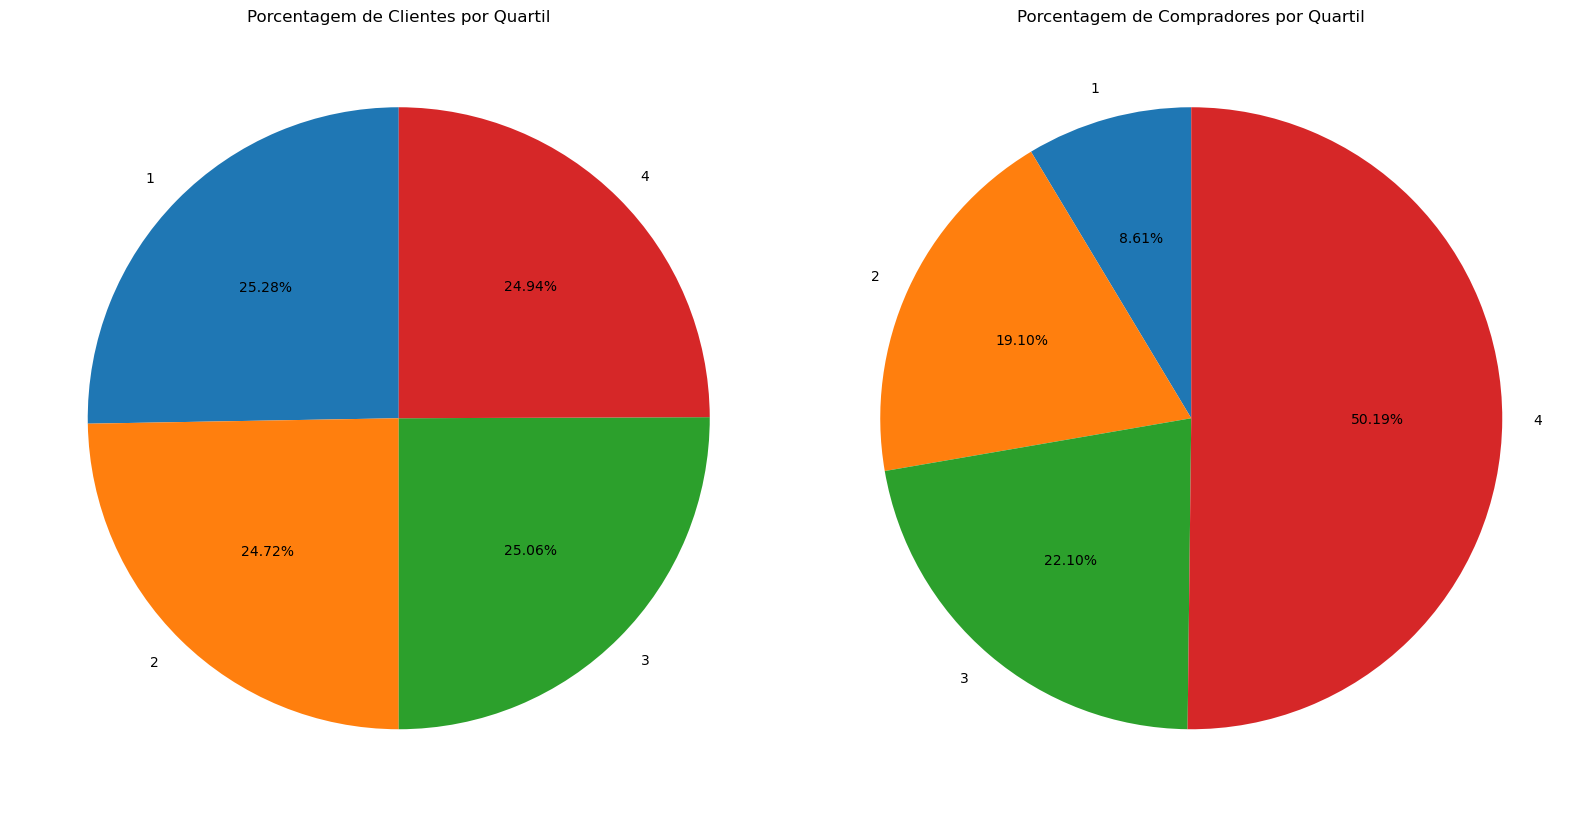

In [54]:
# Tabela de Frequencia (index = Spending_Class, columns = Response)
ct = pd.crosstab(df_train['Spending_Class'], df_train['Response'])

fig, ax = plt.subplots(1, 2, figsize=(16, 9))

# Plot 1: Total Distribution (Sum of columns 0 and 1)
ax[0].pie(ct.sum(axis=1), labels=ct.index, autopct='%1.2f%%', startangle=90)
ax[0].set_title('Porcentagem de Clientes por Quartil')

# Plot 2: Just the Buyers (Column 1)
ax[1].pie(ct[1], labels=ct.index, autopct='%1.2f%%', startangle=90)
ax[1].set_title('Porcentagem de Compradores por Quartil')

plt.tight_layout()
plt.show()

* Muito embora os clientes estejam divididos de maneira uniforme entre as diferentes faixas de renda e de gastos, os compradores se concentram no quartil superior, representando 45.32% e 48.31% das compras, respectivamente. Além disso enquanto por volta de 15% da população geral comprou o produto, por volta de 28% dos clientes das faixas mais altas aceitaram a oferta. De maneira análoga, integrantes das faixas inferiores tiveram menor probabilidade de compra. Apenas 5.08% dos membros dos primeiro quartil (em relação ao dinheiro gasto) efetuaram a compra, no que tange a renda, esse número foi de 9.82%. 

 #### Combinando Income_Class e Spending_Class

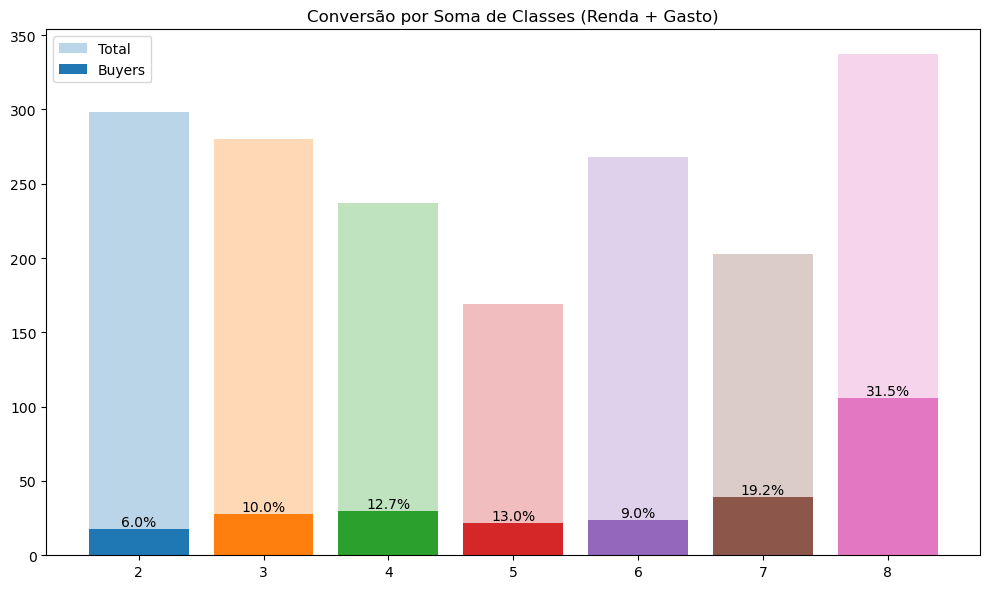

In [56]:
df_train['Sum_Class'] = df_train['Income_Class'].astype(int) + df_train['Spending_Class'].astype(int)

ct_sum = pd.crosstab(df_train['Sum_Class'], df_train['Response'])

fig, ax = plt.subplots(figsize=(10, 6))
ind = np.arange(len(ct_sum))
width = 0.8
colors = [f'C{i}' for i in range(len(ct_sum))]

bar1 = ax.bar(ind, ct_sum.sum(axis=1), width=width, color=colors, alpha=0.3, label='Total')
bar2 = ax.bar(ind, ct_sum[1], width=width, color=colors, label='Buyers')

for i, rect in enumerate(bar2):
    total = ct_sum.sum(axis=1).iloc[i]
    buyers = ct_sum[1].iloc[i]
    percentage = (buyers / total) * 100 if total > 0 else 0
    
    ax.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), 
            f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)

ax.set_xticks(ind)
ax.set_xticklabels(ct_sum.index)
ax.set_title('Conversão por Soma de Classes (Renda + Gasto)')
ax.legend()

plt.tight_layout()
plt.show()

### Conf. Familiar  e Classe

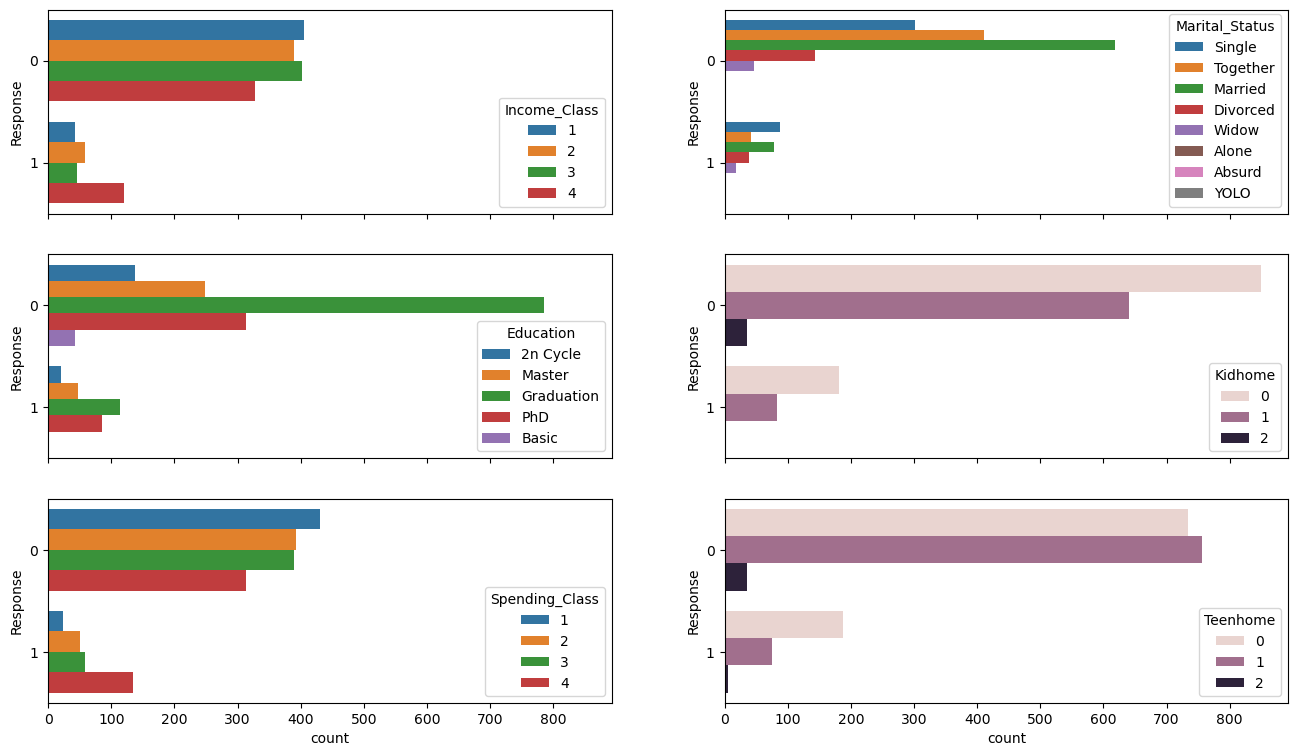

In [57]:
class_cols = ['Income_Class', 'Marital_Status', 'Education', 'Kidhome', 'Spending_Class', 'Teenhome']
fig, axs = plt.subplots(3,2, figsize=(16,9), sharex = True)

for i,col in enumerate(class_cols):
    sns.countplot(y = 'Response',
                hue=col,
                data=df_train,
                ax = axs.flatten()[i])
    axs.flatten()[i].legend(title=f"{col}", loc=4)

* Vemos que o produto tem mais apelo para solteiros e casais com poucos/sem filhos. 

### Campanhas Aceitas

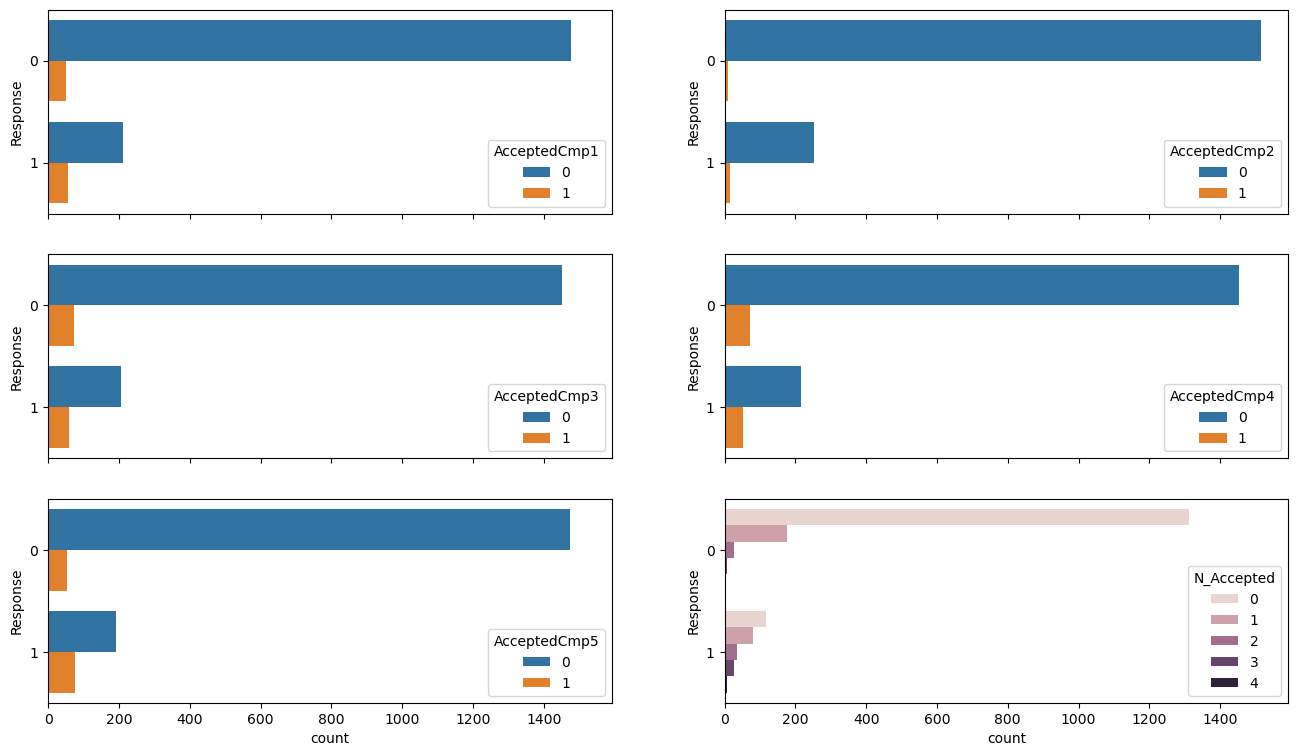

In [58]:
df_train['N_Accepted'] = df_train['AcceptedCmp1'] + df_train['AcceptedCmp2'] + df_train['AcceptedCmp3'] + df_train['AcceptedCmp4'] + df_train['AcceptedCmp5']

promo_cols = ['AcceptedCmp%s'%i for i in range(1,6)] + ['N_Accepted']
fig, axs = plt.subplots(3,2, figsize=(16,9), sharex = True)

for i,col in enumerate(promo_cols):
    sns.countplot(y = 'Response',
                hue=col,
                data=df_train,
                ax = axs.flatten()[i])
    axs.flatten()[i].legend(title=f"{col}", loc=4)


* A maioria dos compradores aceitou 0 ou 1 das outras campanhas de marketing.

### Quantidade Gasta e Atividade

In [59]:
num_cols = [col for col in df_train.columns.tolist() if 'Mnt' in col or 'Num' in col]
num_cols.append('Recency')

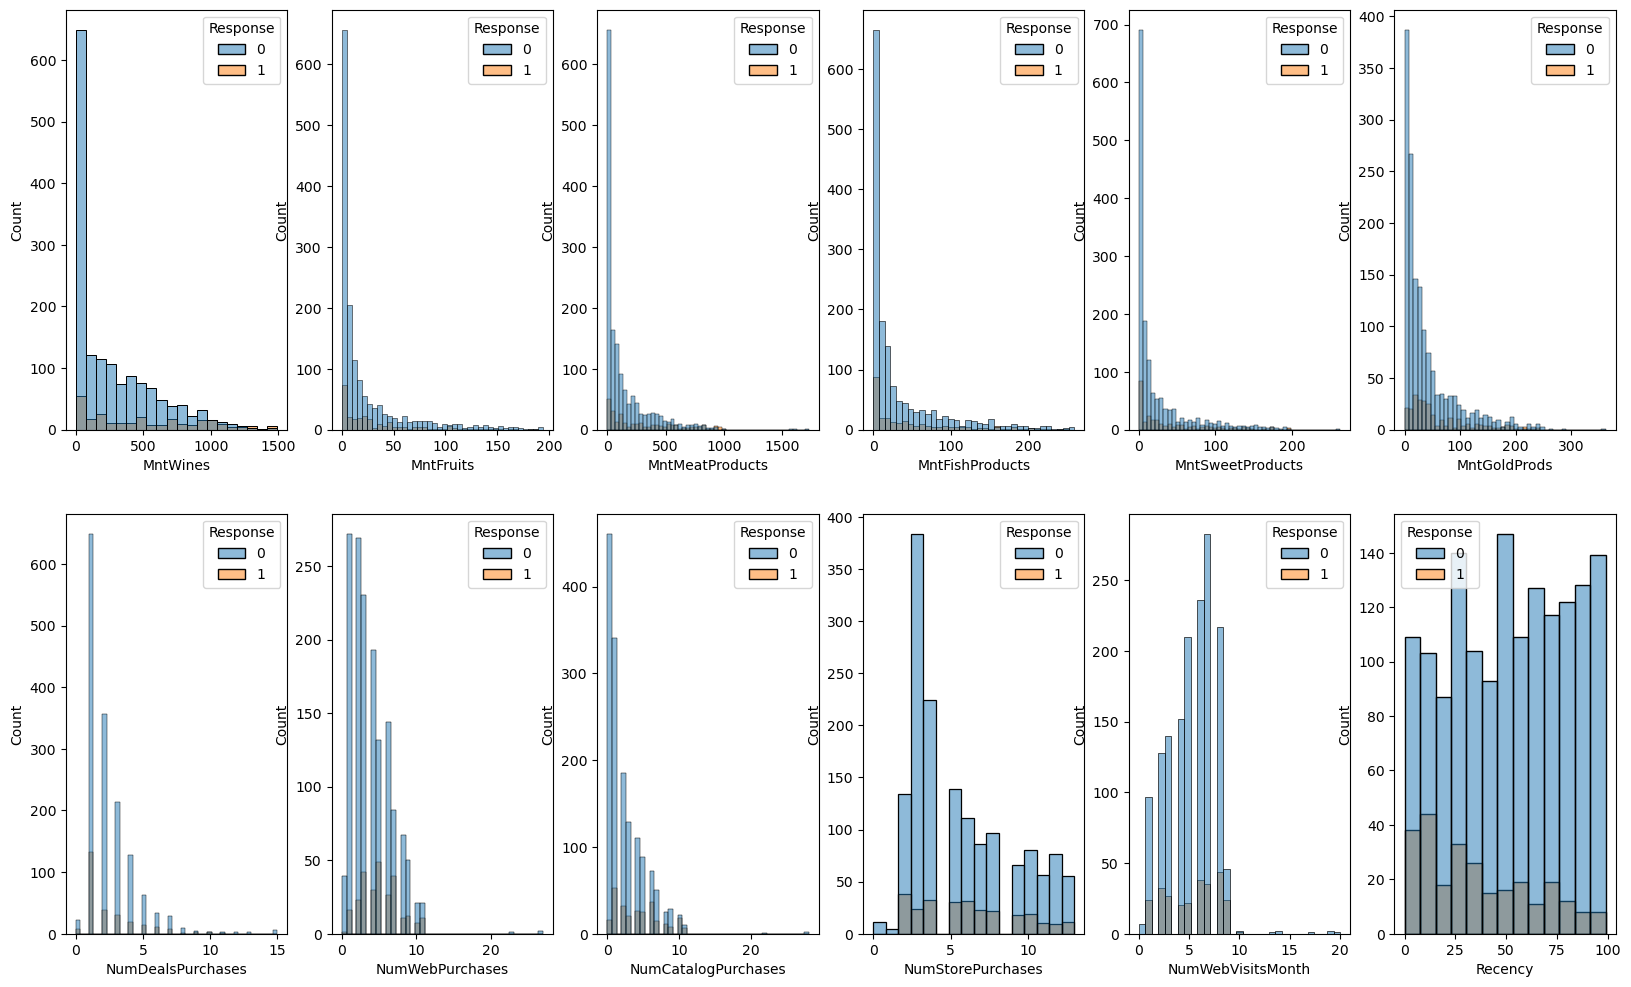

In [60]:
fig, axs = plt.subplots(2,6, figsize = (20,12))
for j, col in enumerate(num_cols):
    sns.histplot(data =df_train, x = col, hue = 'Response', ax = axs.flatten()[j] )

In [61]:
df_train.loc[df_train['Recency']<=50]['Response'].sum()

184

In [62]:
df_train.loc[df_train['Recency']>50]['Response'].sum()

83

* Vemos que 2/3 das compras (184) foram feitas por usuários ativos (menos de 50 dias desde a última compra).

In [63]:
df_train['Active'] = [1 if i<=50 else 0 for i in list(df_train['Recency'])]

### Qualidade

<Axes: xlabel='count', ylabel='Complain'>

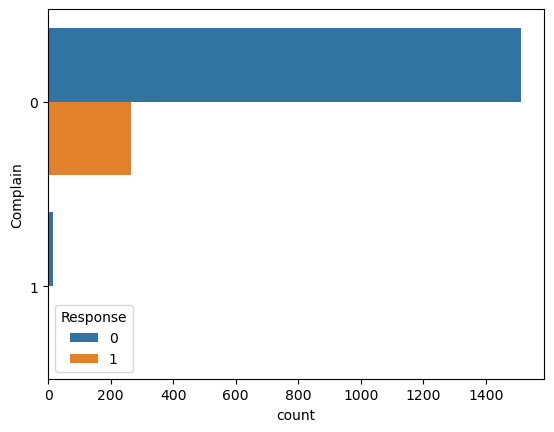

In [64]:
sns.countplot(y = 'Complain',
                hue='Response',
                data=df_train,
              )

* Usuários com reclamação não compraram o produto.

In [66]:
df_train['Income_Class'] = df_train['Income_Class'].astype('object')
df_train['Spending_Class'] = df_train['Spending_Class'].astype('object')
df_train['Dt_Customer'] = datetime.now() - pd.to_datetime(df_train['Dt_Customer'], format = '%Y-%m-%d')
df_train['Dt_Customer'] = df_train['Dt_Customer'].dt.days/365.25 ### Converte para anos
df_train['Active'] = [1 if i<=50 else 0 for i in list(df_train['Recency'])]


In [67]:
def feature_eng(df, dict_test):
    df['Active'] = [1 if i<=50 else 0 for i in list(df['Recency'])]
    df['Total_spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
    df['Spending_Class'] = pd.qcut(df['Total_spent'],q = [0, 0.25, 0.5, 0.75, 1], labels = [1,2,3,4]) ## 1 = primeiro quartil, 2 = segundo quartil.. 
    for classe in list(df['Spending_Class'].unique()):
        df.loc[(df['Spending_Class'] == classe) & (df['Income'].isnull()), 'Income'] = dict_class[classe]
    df['Income_Class'] = pd.qcut(df['Income'],q = [0, 0.25, 0.5, 0.75, 1], labels = [1,2,3,4])
    df['N_Accepted'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
    df['Income_Class'] = df['Income_Class'].astype('object')
    df['Spending_Class'] = df['Spending_Class'].astype('object')
    df['Age'] = 2021 - df['Year_Birth']
    df['Dt_Customer'] = datetime.now() - pd.to_datetime(df['Dt_Customer'], format = '%Y-%m-%d')
    df['Dt_Customer'] = df['Dt_Customer'].dt.days/365.25 ### Converte para anos
    df['Sum_Class'] = df['Spending_Class'] + df['Income_Class']
    return df
    

In [68]:
df_test = feature_eng(df_test, dict_class)

In [69]:
df_test.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
Active                 0
Total_spent            0
Spending_Class         0
Income_Class           0
N_Accepted             0
Age                    0
Sum_Class              0
dtype: int64

In [70]:
df_train.drop(['ID','Year_Birth'], axis = 1, inplace = True)
df_test.drop(['ID', 'Year_Birth'], axis = 1, inplace = True)
df_train.drop(['Z_CostContact', 'Z_Revenue'], axis = 1, inplace = True)
df_test.drop(['Z_CostContact', 'Z_Revenue'], axis = 1, inplace = True)

In [71]:
cat_features = ['Income_Class', 'Spending_Class','Sum_Class', 'Marital_Status', 'Education', 'Active', 'Complain'] + promo_cols 

In [72]:
num_features = [col for col in df_train.columns.tolist() if col not in cat_features]
num_features.remove('Response')

In [73]:
X_train = df_train.drop('Response', axis = 1)
X_test = df_test.drop('Response', axis = 1)
y_train = df_train['Response']
y_test = df_test['Response']

## Filter Methods

In [78]:
select_anova = f_classif(X_train[num_features], y_train)
df_p_num = pd.DataFrame(data = select_anova[1], index = num_features, columns = ['p_value']).sort_values(by = 'p_value', ascending = True)
df_p_num

,p_value
Total_spent,2.279241e-33
MntWines,2.181714e-29
MntMeatProducts,6.641994e-27
NumCatalogPurchases,3.019656e-23
Dt_Customer,5.820538e-18
Recency,2.243951e-15
NumWebPurchases,2.278058e-12
Teenhome,4.643340e-10
MntGoldProds,5.565449e-10
Income,1.598633e-08


* Teste ANOVA para medir a relevância estatística de cada variável numérica em relação ao alvo (Response), ordenando-as pelo p-value (menor valor = maior relevância).

In [75]:
p_values_cat_features = {}
for col in cat_features:
    # Cria tabela de contingencia
    df_cross = pd.crosstab(df_train[col], df_train['Response'])
    # Aplica o teste e extrai o p-valor
    p_value = stats.chi2_contingency(df_cross)[1]
    # Armazena coluna e p-valor em um dict
    p_values_cat_features[col] = p_value

In [76]:
df_p_cat = pd.DataFrame.from_dict(data = p_values_cat_features, orient = 'index', columns = ['p_value']).sort_values(by = 'p_value', ascending = True)
df_p_cat

,p_value
N_Accepted,7.290996e-70
AcceptedCmp5,8.175167e-47
AcceptedCmp1,2.120685e-29
Spending_Class,8.862780e-26
AcceptedCmp3,2.036722e-23
Sum_Class,4.320753e-21
AcceptedCmp4,5.700684e-17
Income_Class,7.806771e-15
AcceptedCmp2,2.889901e-10
Active,2.993619e-10


* Teste Chi^2 para medir a relevância estatística de cada variável categórica em relação ao alvo (Response), ordenando-as pelo p-value (menor valor = maior relevância).

In [79]:
cat_cols_filter = list(df_p_cat.loc[df_p_cat['p_value']<0.05].index)
num_cols_filter = list(df_p_num.loc[df_p_num['p_value']<0.05].index)

## Boruta

In [80]:
for col in cat_features:
    X_train[col] = X_train[col].astype('object')
    X_test[col] = X_test[col].astype('object')

In [81]:
fenc = CountFrequencyEncoder(encoding_method='frequency', variables=cat_features)
# Aplica a transformacao em X_train
X_train_encoded = fenc.fit_transform(X_train)

In [82]:
forest = RandomForestClassifier(n_jobs=-1, max_depth=5)
# Inicializa o Boruta
boruta_selector = BorutaPy(forest, n_estimators=50, max_iter=100, random_state=42)

In [83]:
boruta_selector.fit(np.array(X_train_encoded), y_train)

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=50,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x246362D7D40),
         n_estimators=50, random_state=RandomState(MT19937) at 0x246362D7D40)

O Boruta é um algoritmo de seleção de variáveis baseado em Random Forest.

* O que ele faz: Ele compara a importância de cada variável real com variáveis "sombra" (versões embaralhadas das originais).

* Objetivo: Identificar quais colunas realmente têm poder preditivo e quais são apenas ruído estatístico.

* Resultado: Ele classifica as variáveis em Confirmadas, Rejeitadas ou Indecisas, permitindo que você mantenha apenas o que é essencial para o modelo.

In [86]:
cols_drop_boruta= [not x for x in boruta_selector.support_.tolist()] # apenas invertendo o vetor de true/false
cols_drop_boruta= X_train_encoded.loc[:,cols_drop_boruta].columns.tolist()
cols_keep_boruta = [col for col in X_train_encoded.columns if col not in cols_drop_boruta]

In [88]:
cols_keep_boruta

['Marital_Status',
 'Income',
 'Dt_Customer',
 'Recency',
 'MntWines',
 'MntMeatProducts',
 'MntGoldProds',
 'NumCatalogPurchases',
 'AcceptedCmp3',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'Total_spent',
 'N_Accepted']

In [89]:
weak_cols = X_train_encoded.loc[:, boruta_selector.support_weak_].columns.tolist()

In [90]:
weak_cols

['NumWebVisitsMonth']

In [94]:
filtered_cols = cols_keep_boruta + ['Spending_Class']

* Decidi usar as colunas recomendadas pelo Boruta mais a Spending_Class pois a última pareceu muito relevante de acordo com a análise de estatística descritiva/análise exploratória.

In [95]:
num_cols_filtered = ['Total_spent', 'Income', 'MntWines', 'MntMeatProducts', 'MntGoldProds', 'NumWebVisitsMonth', 'Dt_Customer', 'Recency']
cat_cols_filtered = ['Marital_Status', 'N_Accepted', 'Spending_Class', 'AcceptedCmp1', 'AcceptedCmp3', 'AcceptedCmp5']

In [96]:
selected_cols = num_cols_filtered + cat_cols_filtered
drop_cols = [col for col in X_train.columns if col not in selected_cols]


X_train.drop(drop_cols, axis = 1, inplace = True)
X_test.drop(drop_cols, axis = 1, inplace = True)

## Pre-Processing

In [97]:
pipe_cat_spending = ('ordinal_spending', OrdinalEncoder(categories=[[1,2,3,4]]), ['Spending_Class'])

pipe_cat_Accepted = ('ordinal_accepted', OrdinalEncoder(categories=[[0,1,2,3,4,5]]), ['N_Accepted'])

cat_cols_filtered.remove('Spending_Class')
cat_cols_filtered.remove('N_Accepted')


In [98]:
pipe_cat_onehot = ('OneHot_encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols_filtered)

pipe_num_standard = ('standard_scaler', StandardScaler(), num_cols_filtered)

transformers= [pipe_cat_spending, pipe_cat_Accepted,
                pipe_cat_onehot,
                pipe_num_standard]



pre_processor = ColumnTransformer(transformers)

In [99]:
model_reglog = Pipeline(steps=[('pre_processor', pre_processor), 
                               ('model', LogisticRegression(solver = 'liblinear', 
                                                            random_state=42))])

model_svm = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', SVC(kernel='rbf', probability=True, random_state=42))])

model_knn = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', KNeighborsClassifier())])

model_dt = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', DecisionTreeClassifier(max_depth=5,random_state=42))])

model_rt = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', RandomForestClassifier(random_state=42))])

In [103]:
models = [model_reglog, model_svm, model_knn, model_dt, model_rt]
model_log_loss = []
for model in models:
    model.fit(X_train, y_train)
    name = type(model['model']).__name__
    log_loss_train = log_loss(y_train, model.predict_proba(X_train)[:,1])
    log_loss_test = log_loss(y_test, model.predict_proba(X_test)[:,1])
    model_log_loss.append([name,log_loss_train, log_loss_test])
df_log_loss = pd.DataFrame(data = model_log_loss, columns = ['Model', 'log_loss_train', 'log_loss_test'])
df_log_loss

,Model,log_loss_train,log_loss_test
0,LogisticRegression,0.266411,0.289052
1,SVC,0.253665,0.310340
2,KNeighborsClassifier,0.190476,1.475165
3,DecisionTreeClassifier,0.240963,0.640992
4,RandomForestClassifier,0.076838,0.293966


* Vemos que tanto RegLog quanto a SVC tem uma performance similar entre o dataset de treino e o dataset de teste, isso indica que o modelo não está fazendo underfit e nem overfit dos dados. Para os algoritmos de KNN, de DecisionTree e RandomForest no entanto, a performance é muito melhor nos dados de treino do que nos dados de teste, isso sugere que estes algorimos estão fazendo overfit dos dados e que uma escolha melhor de hiperparâmetros se faz necessária para dar conta deste comportamento.  

## Hiperparametros

In [212]:
model_reglog = Pipeline(steps=[('pre_processor', pre_processor), 
                               ('model', LogisticRegression(solver = 'liblinear', 
                                                            random_state=42))])

model_svm = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', SVC(kernel='rbf', probability=True, random_state=42))])

model_knn = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', KNeighborsClassifier())])

model_dt = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', DecisionTreeClassifier(random_state=42))])

model_rt = Pipeline(steps=[('pre_processor', pre_processor),
                            ('model', RandomForestClassifier(random_state=42))])

In [216]:
grid_lr = dict(model__C=uniform(loc=0, scale=3), model__class_weight=['balanced', None], model__penalty = ['l1', 'l2'])

grid_svm = dict(model__C=uniform(loc=0, scale = 15), model__kernel = ['poly', 'rbf'], model__class_weight=['balanced', None])

grid_knn = dict(model__n_neighbors=list(np.arange(21,120)), model__weights = ['uniform','distance'], model__p = list(np.arange(1,20)))

grid_dt = dict(model__criterion = ['gini', 'entropy'], model__max_depth = [2,3], model__min_samples_leaf = list(np.arange(1,50)), model__min_samples_split = list(np.arange(1,50)))

grid_rf =  dict(model__n_estimators = [200,300,400,600,800], 
               model__bootstrap = [True,False],
               model__max_depth =[3,5,10,20,50,75,None],
               model__max_features = ['auto'],
               model__min_samples_leaf = [1,2,4,6,10],
               model__min_samples_split =[2,5,10,20])

In [217]:
grids = [grid_lr, grid_svm, grid_knn, grid_dt, grid_rf]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
hyper_list = [(models[i],grids[i]) for i in range(len(models))]

In [219]:
info_models = []
for count, model in enumerate(hyper_list):
    name = type(model[0]['model']).__name__,
    random_search = RandomizedSearchCV(model[0], model[1], 
                                       n_iter=400, cv=skf, scoring='neg_log_loss', 
                                       verbose=1, random_state=42, n_jobs  = -1)
    random_search.fit(X_train, y_train)
    params = random_search.best_params_
    best_score = random_search.best_score_
    model[0].set_params(**params)
    model[0].fit(X_train, y_train)
    acc_train = model[0].score(X_train, y_train)
    y_predict = model[0].predict(X_test)
    accuracy = accuracy_score(y_predict, y_test)
    recall = recall_score(y_predict, y_test)
    precision = precision_score(y_predict, y_test)
    info_models.append([name, params, best_score, acc_train, accuracy, recall, precision])

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   27.1s finished


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  4.1min finished


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.2min finished


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   23.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 19.6min finished


In [220]:
df_models = pd.DataFrame(data = info_models, columns = ['Model', 'Params' , 'neg_log', 'acc_train', 'acc_test', 'recall', 'precision'])

In [221]:
pd.set_option("max_colwidth", 150)

In [222]:
df_models

,Model,Params,neg_log,acc_train,acc_test,recall,precision
0,"(LogisticRegression,)","{'model__C': 0.21828901909258058, 'model__class_weight': None, 'model__penalty': 'l1'}",-0.289440,0.883929,0.910714,0.800000,0.537313
1,"(SVC,)","{'model__C': 0.38026115123186266, 'model__class_weight': 'balanced', 'model__kernel': 'rbf'}",-0.287612,0.789621,0.772321,0.388535,0.910448
2,"(KNeighborsClassifier,)","{'model__weights': 'uniform', 'model__p': 1, 'model__n_neighbors': 70}",-0.317657,0.863281,0.872768,1.000000,0.149254
3,"(DecisionTreeClassifier,)","{'model__min_samples_split': 47, 'model__min_samples_leaf': 39, 'model__max_depth': 3, 'model__criterion': 'entropy'}",-0.344603,0.867746,0.875000,0.587302,0.552239
4,"(RandomForestClassifier,)","{'model__n_estimators': 800, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'auto', 'model__max_depth': None...",-0.292256,0.953125,0.897321,0.783784,0.432836


In [283]:
#df_models.to_csv('params.csv', index = False)

## Threshold

In [224]:
def threshold_test(prob, y_test):
    acc = []
    threshold = 0
    for i in range(101):
        threshold += 0.01
        y_predict = np.array([0 if x>=threshold else 1 for x in prob])
        accuracy = accuracy_score(y_test, y_predict)
        acc.append([threshold,accuracy])
    return acc

In [225]:
tresh_model = []
for i in range(len(info_models)):
    name = info_models[i][0]
    models[i].set_params(**info_models[i][1])
    models[i].fit(X_train, y_train)
    y_predict = models[i].predict(X_test)
    prob = [x[0] for x in models[i].predict_proba(X_test)]
    tt = threshold_test(prob, y_test)
    tt.sort(key=lambda x:x[1], reverse = True)
    tresh = tt[0][0]
    best_acc = tt[0][1]
    tresh_model.append([name,tresh, best_acc])

## Resultados

In [226]:
df_tresh = pd.DataFrame(data = tresh_model, columns = ['Name', 'Tresh', 'best_acc'])

In [229]:
df_tresh.sort_values(by = 'best_acc', ascending = False)

,Name,Tresh,best_acc
4,"(RandomForestClassifier,)",0.61,0.924107
0,"(LogisticRegression,)",0.55,0.912946
2,"(KNeighborsClassifier,)",0.70,0.906250
1,"(SVC,)",0.53,0.895089
3,"(DecisionTreeClassifier,)",0.50,0.875000


* RandomForestClassifier e RegLog apresentam os melhores resultados, identificando mais de 90% dos casos positivos.